In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [2]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0
    for expression in os.listdir("dataset_fer/test"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("dataset_fer/test/" + expression + "/" +os.listdir("dataset_fer/test/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

## Visualizing the Dataset

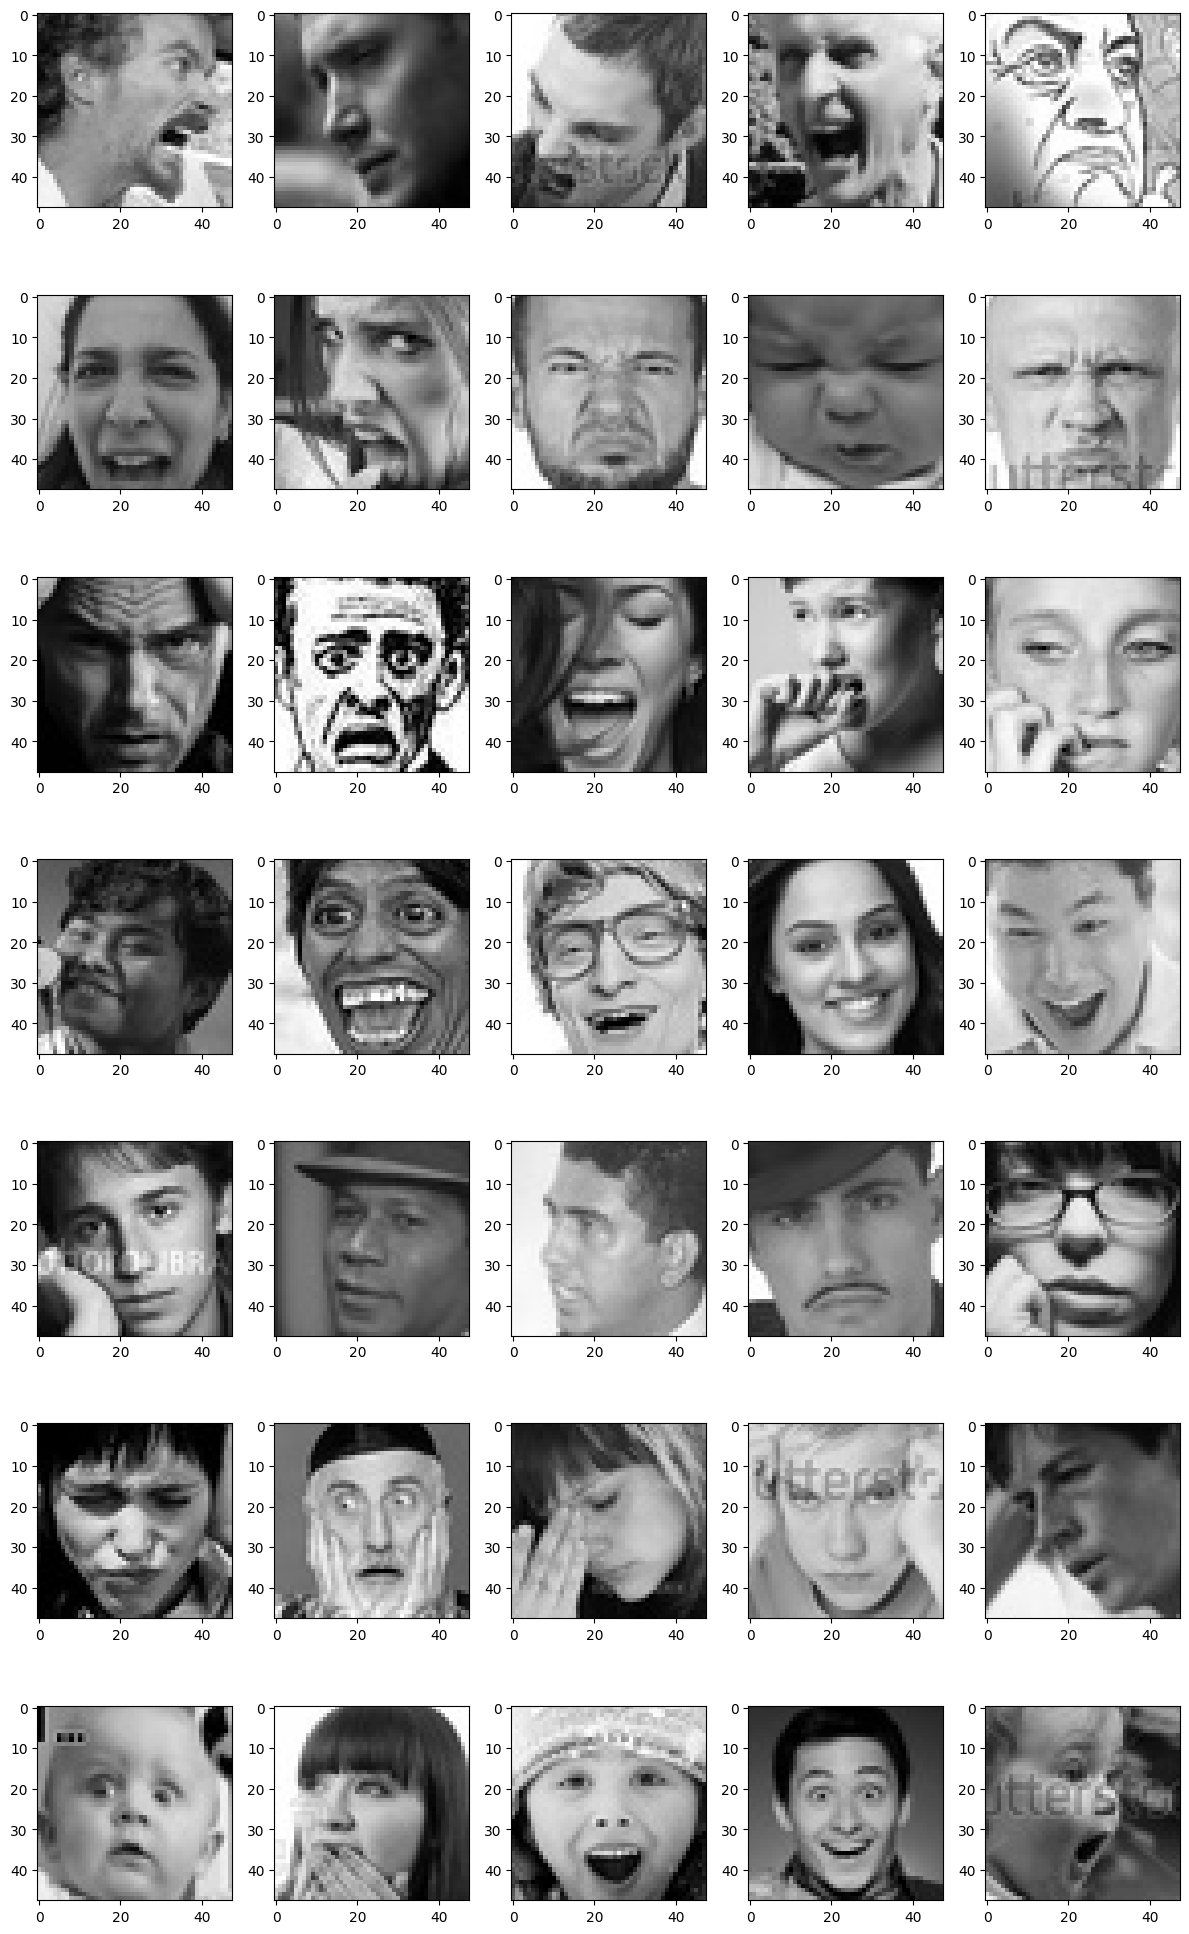

In [3]:
plot_example_images(plt).show()

In [4]:
df = {}
for expression in os.listdir("dataset_fer/train/"):
    directory = "dataset_fer/train/" + expression
    df[expression] = len(os.listdir(directory))
df = pd.DataFrame(df, index=[0])

In [5]:
pd.options.plotting.backend = "plotly"
fig = df.transpose().plot.bar()
fig.show()


## Generating Training Data

In [6]:
img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory("dataset_fer/train/", target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

test_generator = test_datagen.flow_from_directory("dataset_fer/test/", target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## CNN Model

Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. Neural Networks, 64, 59-63. doi:10.1016/j.neunet.2014.09.005

* Human accuracy on the FER-2013 was 65 ± 5%

In [7]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same',
                           input_shape=(48, 48, 1),
                          kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (5, 5), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Conv2D(512, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(512, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])
# Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint("os./model_weights.h5", monitor='val_accuracy',
                            save_weights_only = True,
                            mode = 'max',
                            verbose = 1)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer, checkpointer]

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.8610 - accuracy: 0.2846
Epoch 1: saving model to os.\model_weights.h5

Epoch 1: val_loss improved from inf to 1.92798, saving model to model.h5


c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



448/448 [==============================] - 952s 2s/step - loss: 1.8610 - accuracy: 0.2846 - val_loss: 1.9280 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 2/15
 88/448 [====>.........................] - ETA: 8:17 - loss: 1.6301 - accuracy: 0.3786

## Visualising the training over time

In [42]:
epochs = epochs
metric = "loss"
metric2 = "accuracy"
train_m1 = history.history[metric]
train_m2 = history.history[metric2]
val_m1 = history.history[f'val_{metric}']
val_m2 = history.history[f'val_{metric2}']

fig_model = make_subplots(1,
                          2,
                          subplot_titles=(f"{metric.capitalize()} over Time",
                                          f"{metric2.capitalize()} over Time"))
fig_model.add_trace(go.Scatter(x=np.arange(epochs),
                               y=train_m1,
                               mode="lines+markers",
                               name=f"Training {metric.capitalize()}"),
                    row=1,
                    col=1)
fig_model.add_trace(go.Scatter(x=np.arange(epochs),
                               y=val_m1,
                               mode="lines+markers",
                               name=f"Validation {metric.capitalize()}"),
                    row=1,
                    col=1)

fig_model.add_trace(go.Scatter(x=np.arange(epochs),
                               y=train_m2,
                               mode="lines+markers",
                               name=f"Training {metric2.capitalize()}"),
                    row=1,
                    col=2)
fig_model.add_trace(go.Scatter(x=np.arange(epochs),
                               y=val_m2,
                               mode="lines+markers",
                               name=f"Validation {metric2.capitalize()}"),
                    row=1,
                    col=2)
fig_model.show()

## Exporting the Model

In [41]:
model_json = model.to_json()
with open("model.json", "w") as f:
    f.write(model_json)